In [9]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, Coupling, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt
from math import lcm

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [10]:

# RC square wave model with offset: combines exponential rise and fall with DC offset
def rc_square_wave_with_offset(t, frequency, amplitude, phase, amp_discharge, rc, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase

    # smoothness = 0.2*(t[1]-t[0])
    smoothness = period/1000.0
    smoothedge1 = 1 - np.exp(-t_shifted / smoothness)-np.exp(-(half_period-t_shifted) / smoothness)
    smoothedge2 = 1 - np.exp(-(t_shifted - half_period) / smoothness)-np.exp(-(period-t_shifted) / smoothness)

    rc_wave = np.zeros_like(t)
    flipflop = t_shifted < half_period
    rcwave_fronthalf = (amplitude*smoothedge1-amp_discharge * (1 - np.exp(-t_shifted / rc)))
    rcwave_endhalf = (-amplitude*smoothedge2+amp_discharge * (1 - np.exp(-(t_shifted - half_period) / rc)))
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset

def square_wave_with_offset(t, frequency, amplitude, phase, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase
    rc_wave = np.zeros_like(t)
    # smoothness = 0.2*(t[1]-t[0])
    smoothness = period/1000.0
    smoothedge1 = 1 - np.exp(-t_shifted / smoothness)-np.exp(-(half_period-t_shifted) / smoothness)
    smoothedge2 = 1 - np.exp(-(t_shifted - half_period) / smoothness)-np.exp(-(period-t_shifted) / smoothness)
    flipflop = t_shifted < half_period
    rcwave_fronthalf = amplitude*smoothedge1
    rcwave_endhalf = -amplitude*smoothedge2
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset
def estimate_rcsquare(xx, yy):
    amp_guess = (np.max(yy)-np.min(yy))/2.0
    yybase = np.mean(yy)
    yy_shifted = yy - yybase
    idx_neg = np.where(yy_shifted<0)[0][0]
    idx_pos = np.where(yy_shifted>0)[0][0]
    initial_guess = [0.5/abs(xx[idx_neg]-xx[idx_pos]), amp_guess, 0.1, amp_guess, 25E3, yybase]
    return initial_guess
def fit_rcsquare(xx, yy, initial_guess, bounds):
    # do a fit------------------------------
    params_opt, params_cov = curve_fit(rc_square_wave_with_offset, xx, yy, p0=initial_guess, bounds=bounds)
    # params_opt, params_cov = curve_fit(rc_square_wave_with_offset, xx, yy, p0=initial_guess)

    return params_opt, params_cov

In [11]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=hcf.PS_choffs) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# pg.reset()
# mwsyn.reboot()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [12]:
paraset = dict(
    mwfreq = 398.556, # [GHz] MW frequency after AMC
    mwpower = 5.0, #[V]
    pulse_rate = 0.1E6,#[Hz], better to be multiple of the daq sampling rate
    daq_max = 0.02, #[V]
    daq_min = -0.02, #[V]
    daq_srate = hcf.NI_sampling_max, #[Hz]
    refresh = 50, #[Hz]
    window = 180#[s]
)
mwfreq = paraset["mwfreq"] # [GHz] 
mwpower = paraset["mwpower"] #[V]
pulse_rate = paraset["pulse_rate"]#[Hz]
daq_max = paraset["daq_max"] #[V]
daq_min = paraset["daq_min"] #[V]
daq_srate = paraset["daq_srate"] #[Hz]
refresh = paraset["refresh"] #[Hz]
window = paraset["window"] #[s]


In [13]:
# set MW frequency =====================================================
freq = mwfreq/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
paraset["mwfreq"] = freq_actual
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

# set MW power =====================================================
mwpower_vlevel = mwpower # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=mwpower_vlevel*1.01)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel])

CW Freqeuncy Setting Sent:16.6065 GHz
Actual Output CW Freqeuncy :16.60650000348687 GHz


1

In [14]:
# here we set up the parameters for the instruments------------------------
dt_daq = int(1.0/daq_srate*1E9) # ns

dt_pulse = int(1/pulse_rate*1E9) # [ns]
leastrepeat = lcm(dt_daq, dt_pulse)
num_read = int(-(((1E9/refresh)/leastrepeat)//-1)*leastrepeat/dt_daq)
# num_read = int(daq_srate/refresh)
# set up the NI DAQ board-----------------------------------------------
task_zbd = nidaqmx.Task("ZBD") # user controlled attenuation
task_zbd.ai_channels.add_ai_voltage_chan(hcf.NI_ch_ZBD, min_val=daq_min, max_val=daq_max)
task_zbd.ai_coupling = Coupling.AC
task_zbd.timing.cfg_samp_clk_timing(daq_srate, 
                                    source=hcf.NI_ch_Clock, 
                                    active_edge=Edge.RISING,
                                    sample_mode=AcquisitionType.CONTINUOUS)
task_zbd_readtrig = task_zbd.triggers.start_trigger
task_zbd_readtrig.cfg_dig_edge_start_trig(
    hcf.NI_ch_Trig, Edge.RISING
)
task_zbd_readtrig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)
task_zbd_reader = AnalogSingleChannelReader(task_zbd.in_stream)
task_zbd_reader.read_all_avail_samp  = True
#-------------------------------------------------------------------------

# set the pulse sequence --------------------------------------------
pg.resetSeq()
pg.setDigital("dtrig", [(dt_daq/2.0, HIGH), (dt_daq/2.0, LOW)], offset=False)
pg.setDigital("mwA", [(dt_pulse/2.0, LOW), (dt_pulse/2.0, HIGH)]*int(leastrepeat/dt_pulse), offset=False)
pg.setDigital("mwB", [(dt_pulse/2.0, LOW), (dt_pulse/2.0, LOW)]*int(leastrepeat/dt_pulse), offset=False)
pg.setDigital("dclk", [(dt_daq/2.0, LOW), (dt_daq/2.0, HIGH)]*int(leastrepeat/dt_daq), offset=False)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
pg.stream(n_runs=REPEAT_INFINITELY)
# -----------------------------------------------------------------------
# Start the task
task_zbd.start()
pg.startNow()

## here is inside the measurement event loop-------------------------
# dt = 1E9/daq_srate # ns
div = int(daq_srate/pulse_rate)
num_ptrepeat = int(num_read/div)
num_window = int(refresh*window)


daq_buffer = np.zeros(num_read, dtype=np.float64, order='C')
zbd_amptrace = np.zeros(num_window, dtype=np.float64, order='C')
zbd_ffttrace = np.zeros(num_window, dtype=np.float64, order='C')
zbd_avtrace = np.zeros(num_window, dtype=np.float64, order='C')
zbd_ttrace = np.arange(0, window, 1.0/refresh)
num_run = 100000
idx_run = 0
zbd_time = np.arange(0, div*dt_daq, dt_daq)
zbd_samples = np.zeros(num_read, dtype=np.float64, order='C')
zbd_aetrace = np.zeros(num_window, dtype=np.float64, order='C')
fit_bounds = ([0.0, 0.0, 0.0, 0.0, 0.0, -np.inf], [np.inf, np.inf, np.pi*2.0, np.inf, np.inf, np.inf])
time_start = time.time()
time_record = []
time_run = 0
for _ in range(num_run):
    task_zbd_reader.read_many_sample(
        daq_buffer, 
        number_of_samples_per_channel=num_read,
        timeout=10.0
    )
    idx_run += 1
    if idx_run > num_window:
        break

    # some basic data analysis-------------------------------
    daq_buffer_copy = np.copy(daq_buffer)

    # perform numerical fit-----------------------
    zbd_samples_reshape = np.reshape(daq_buffer_copy, (num_ptrepeat, div))
    zbd_samples = np.average(zbd_samples_reshape, axis=0)
    para_guess = estimate_rcsquare(zbd_time, zbd_samples)
    para_fit, params_cov = fit_rcsquare(zbd_time,zbd_samples, initial_guess=para_guess, bounds=fit_bounds)
    amp = para_fit[1]
    zbd_amptrace[:-1] = zbd_amptrace[1:]
    zbd_amptrace[-1] = amp
    amp_error = np.sqrt(np.diag(params_cov))[1]
    zbd_aetrace[:-1] = zbd_aetrace[1:]
    zbd_aetrace[-1] = amp_error
    # ---------------------------------------------

    # Perform FFT on the signal----------------------------------
    fft_result = np.fft.fft(daq_buffer_copy)
    fft_freqs = np.fft.fftfreq(num_read, 1/dt_daq)
    # Get the positive frequencies and corresponding FFT values
    positive_freqs = fft_freqs[fft_freqs >= 0]
    positive_fft = np.abs(fft_result[fft_freqs >= 0])
    # Find the peak amplitude at a specific frequency (e.g., 50 Hz)
    target_frequency = pulse_rate/1E9
    idx = (np.abs(positive_freqs - target_frequency)).argmin()  # Find the closest frequency bin
    peak_amplitude = positive_fft[idx]
    zbd_ffttrace[:-1] = zbd_ffttrace[1:]
    zbd_ffttrace[-1] = peak_amplitude/num_read*2
    #------------------------------------------------------------

    # Perform average on the signal absolute----------------------------------
    signal_nofloor = daq_buffer_copy - np.average(daq_buffer_copy)
    amp_av = np.average(np.abs(signal_nofloor))
    zbd_avtrace[:-1] = zbd_avtrace[1:]
    zbd_avtrace[-1] = amp_av
    #------------------------------------------------------------

    time_now = time.time()
    time_single = time_now - time_start - time_run 
    time_run = time_now - time_start
    time_record.append(time_single)
# here we finish the measurement-------------------
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()

task_zbd.stop()
task_zbd.close()

task_uca.write([0])
task_uca.stop()
task_uca.close()

mwsyn.close()

C:\Users\ctcheung\AppData\Local\Temp\ipykernel_49116\361969770.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, params_cov = curve_fit(rc_square_wave_with_offset, xx, yy, p0=initial_guess, bounds=bounds)


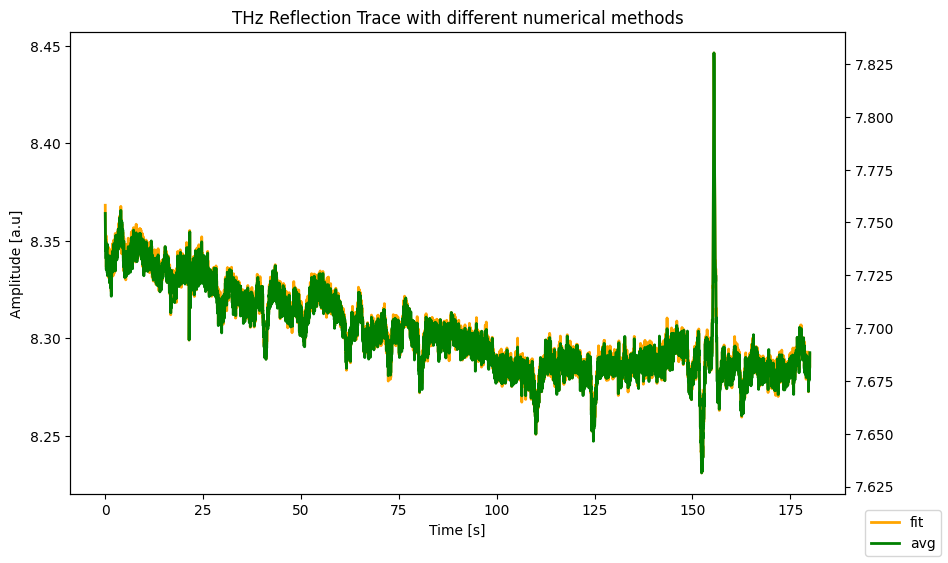

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
# ax3 = ax1.twinx()
# ax1.errorbar(zbd_ttrace, zbd_amptrace*1E3, zbd_aetrace*1E3, linewidth=2, label="fit", color="orange")
ax1.plot(zbd_ttrace, zbd_amptrace*1E3, linewidth=2, label="fit", color="orange")
ax2.plot(zbd_ttrace, zbd_avtrace*1E3, linewidth=2, label="avg", color="green")
# ax3.plot(zbd_ttrace, zbd_ffttrace*1E3, linewidth=2, label="fft", color='royalblue')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude [a.u]')
fig.legend(loc='lower right')
plt.title("THz Reflection Trace with different numerical methods")
plt.show()

C:\Users\ctcheung\AppData\Local\Temp\ipykernel_49116\361969770.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, params_cov = curve_fit(rc_square_wave_with_offset, xx, yy, p0=initial_guess, bounds=bounds)


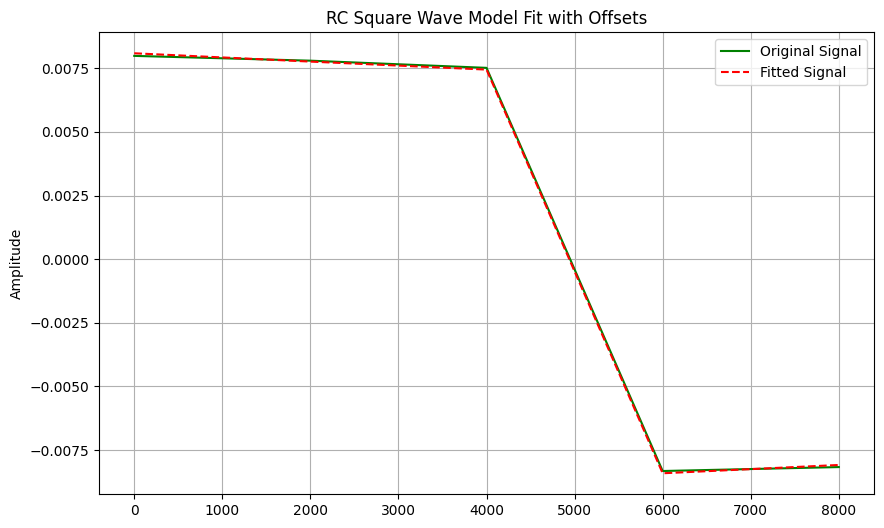

Fitted Parameters:
RC Square Wave 1:
  Frequency: 84.55 kHz
  Amplitude: 8.29 mV
  Phase: 5.80 deg
  Dsicharge Amp.: 8.42 mV
  RC Time Constant: 50.3163 us
  Offset: -0.17 mV


In [16]:
params_opt, _ = fit_rcsquare(zbd_time, zbd_samples, initial_guess=para_fit, bounds=fit_bounds)
fitted_signal = rc_square_wave_with_offset(zbd_time, *params_opt)
# Plot the original and fitted signals-----------------------
plt.figure(figsize=(10, 6))
plt.plot(zbd_time, zbd_samples, label="Original Signal", color='green')
plt.plot(zbd_time, fitted_signal, label="Fitted Signal", linestyle="--", color='red')
plt.title('RC Square Wave Model Fit with Offsets')
# plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized parameters
num_waves = len(params_opt) // 5
print("Fitted Parameters:")
for i in range(num_waves):
    print(f"RC Square Wave {i+1}:")
    print(f"  Frequency: {1E9*params_opt[i*5]/1E3:.2f} kHz")
    print(f"  Amplitude: {params_opt[i*5+1]*1E3:.2f} mV")
    print(f"  Phase: {180/np.pi*params_opt[i*5+2]:.2f} deg")
    print(f"  Dsicharge Amp.: {params_opt[i*5+3]*1E3:.2f} mV")
    print(f"  RC Time Constant: {params_opt[i*5+4]/1E3:.4f} us")
    print(f"  Offset: {params_opt[i*5+5]*1E3:.2f} mV")